This notebook is created for the **Myelin Foundry AI Challenge** at [Myelin GitHub](https://github.com/myelinfoundry-2019/challenge).

My details:
* Name: Gaurav Sharma
* College: SRM Institute of Science & Technology
* College ID No: RA1711008010224
* E-Mail ID: gn9787@srmist.edu.in





In [1]:
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import os

# Tensorflow Keras is used for model
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16

# L-BFGS algorithm is used for optimization
from scipy.optimize import fmin_l_bfgs_b  

The challenge was completed by referring to the research paper titled [Image Stye Transfer using CNN, 2016](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf).

For setting the **hyperparameters**, this [article](https://towardsdatascience.com/practical-techniques-for-getting-style-transfer-to-work-19884a0d69eb#:~:text=Total%20variation%20loss%20is%20the,noise%20is%20in%20the%20images.) was referred.

In [2]:
tf.compat.v1.disable_eager_execution()

# Hyperparameters
ITERATIONS = 10
CHANNELS = 3
IMAGE_WIDTH = 512
IMAGE_HEIGHT = 512
IMAGENET_MEAN_RGB_VALUES = [123.68, 116.779, 103.939] # taken from internet
CONTENT_WEIGHT = 0.02
STYLE_WEIGHT = 4.5
TOTAL_VARIATION_WEIGHT = 0.995
TOTAL_VARIATION_LOSS_FACTOR = 1.25

In [3]:
content_img_path = '/content/japanese_garden.jpg'

style_img_path = '/content/picasso_selfportrait.jpg'

output_img_path = '/content/output_image.jpg'

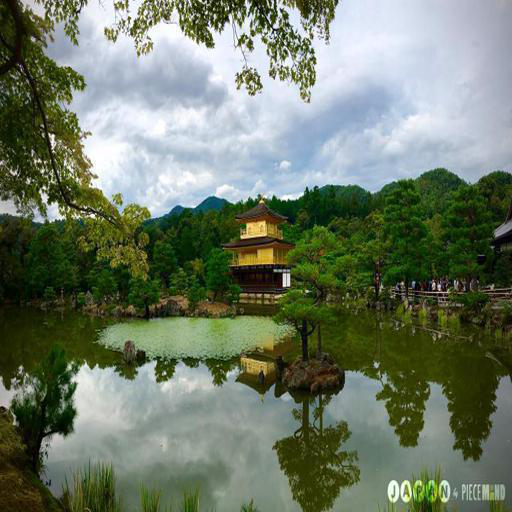

In [4]:
input_image = Image.open(content_img_path)
input_image = input_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
input_image.save(content_img_path)
input_image

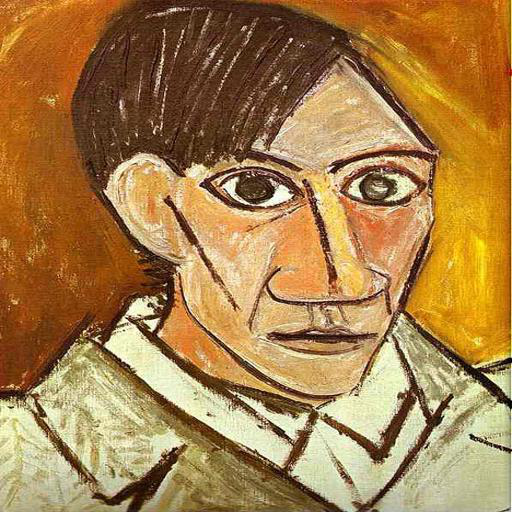

In [5]:
style_image = Image.open(style_img_path)
style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
style_image.save(style_img_path)
style_image

In [6]:
# Data normalization and reshaping from RGB to BGR

input_image_array = np.asarray(input_image, dtype="float32")
input_image_array = np.expand_dims(input_image_array, axis=0)
input_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
input_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
input_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
input_image_array = input_image_array[:, :, :, ::-1]

style_image_array = np.asarray(style_image, dtype="float32")
style_image_array = np.expand_dims(style_image_array, axis=0)
style_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
style_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
style_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
style_image_array = style_image_array[:, :, :, ::-1]

In [7]:
# Model
input_image = backend.variable(input_image_array)
style_image = backend.variable(style_image_array)
combination_image = backend.placeholder((1, IMAGE_HEIGHT, IMAGE_WIDTH, 3))

input_tensor = backend.concatenate([input_image,style_image,combination_image], axis=0)
print(np.shape(input_tensor))
model = VGG16(input_tensor=input_tensor, include_top=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
(3, 512, 512, 3)


In [8]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layers = dict([(layer.name, layer.output) for layer in model.layers])

for layer in layers:
  print(layer)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


**style_layers** and **content_layer** are chosen after referring to the research paper and the article.

In [9]:
content_layer = 'block2_conv2'
layer_features = layers[content_layer]
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = backend.variable(0.)
loss = loss + ( CONTENT_WEIGHT * content_loss(content_image_features, combination_features) )

In [10]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

def compute_style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = IMAGE_HEIGHT * IMAGE_WIDTH
    return backend.sum(backend.square(style - combination)) / (4. * (CHANNELS ** 2) * (size ** 2))

style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss += (STYLE_WEIGHT / len(style_layers)) * style_loss

In [11]:
def total_variation_loss(x):
    a = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, 1:, :IMAGE_WIDTH-1, :])
    b = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, :IMAGE_HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))

loss += TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image)

In [12]:
outputs = [loss]
outputs += backend.gradients(loss, combination_image)

def evaluate_loss_and_gradients(x):
    x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    outs = backend.function([combination_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

evaluator = Evaluator()

Loss function minimized: **Ltotal(p, a, x) = αLcontent(p, x) + βLstyle(a, x)**

This function is taken from the research paper whose link is shared in beginning of notebook.

In [13]:
x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128.

for i in range(ITERATIONS):
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration %d completed with loss %d" % (i, loss))
    


Iteration 0 completed with loss 83161661440
Iteration 1 completed with loss 39343730688
Iteration 2 completed with loss 26500562944
Iteration 3 completed with loss 21879971840
Iteration 4 completed with loss 19277727744
Iteration 5 completed with loss 17984591872
Iteration 6 completed with loss 16942651392
Iteration 7 completed with loss 16451450880
Iteration 8 completed with loss 16120153088
Iteration 9 completed with loss 15912710144


In [14]:
x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
x = x[:, :, ::-1]
x[:, :, 0] += IMAGENET_MEAN_RGB_VALUES[2]
x[:, :, 1] += IMAGENET_MEAN_RGB_VALUES[1]
x[:, :, 2] += IMAGENET_MEAN_RGB_VALUES[0]
x = np.clip(x, 0, 255).astype("uint8")

Final Image:


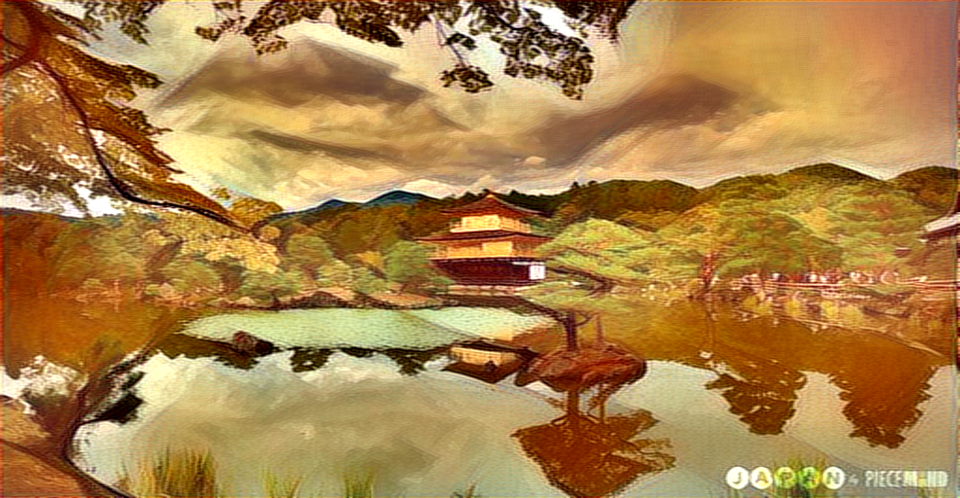

In [16]:
output_image = Image.fromarray(x)
output_image=output_image.resize((960, 498))
output_image.save(output_img_path)
print("Final Image:")
output_image